# Lancelot compilation

## Setup

We set up our notebook environment, so that graphs are displayed nicely.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

import seaborn as sb
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

import numpy as np

## Preprocessing

We create a function that we can use to extract lines from the XML-formatted text under the `data` directory (mostly *Cd-rom Middelnederlands* version, courtesy of the [Dutch Language Institute](http://www.inl.nl/)). We ignore lines that have text loss (cf. the `damage` tag) and remove all non-alphabetic characters.

In [2]:
from lxml import etree

def preprocess_file(fn, target_scribes):

    with open(fn, 'r') as f:
        xml_text = f.read()

    root = etree.fromstring(xml_text)

    scribes, current_scribe = {}, None

    for line in root.findall('.//l'):
        for child in list(line):
            if child.tag == 'scribe':
                current_scribe = child.get('id')
                if current_scribe not in scribes and \
                  current_scribe in target_scribes:
                    scribes[current_scribe] = []

        if current_scribe and current_scribe in target_scribes:

            # ignore lines with a damage tag:
            damaged = False
            for child in line:
                if child.tag == 'damage':
                    print(' '.join([t.strip() for t in line.itertext()]))
                    damaged = True
                    break

            if not damaged:
                line_text = ' '.join([t.strip() for t in line.itertext()])
                line_text = ''.join([c for c in line_text if c.isalpha() or c.isspace()])

                scribes[current_scribe].append(line_text.strip().lower())

    return scribes

We extract the lines from all scribes in the *Lanceloet* part (`A, B, C, D, E`), but we also include the *Perchevael*(written entirely by `B`), to bring B's share up to the level of the other scribes. Note that A, nevertheless, still severely outnumbers the other copyists.

In [3]:
scribes = preprocess_file(fn='../data/compilation/01Lanc.xml',
                          target_scribes=['A', 'B', 'C', 'D', 'E'])

scribes['B'].extend(preprocess_file(fn='../data/compilation/02Perc.xml',
                          target_scribes=['B'])['B'])

for scribe, lines in scribes.items():
    scribes[scribe] = tuple(lines)

for scribe, lines in scribes.items():
    print(f'{scribe} -> {len(lines)} lines')

A -> 17475 lines
B -> 7085 lines
C -> 7080 lines
D -> 6639 lines
E -> 4264 lines


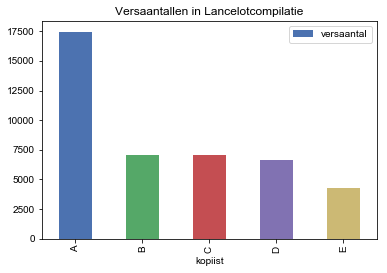

In [4]:
import pandas as pd
df = pd.DataFrame()
df['kopiist'] = sorted(scribes.keys())
df['versaantal'] = [len(scribes[s]) for s in sorted(scribes.keys())]
df.plot(kind='bar', x='kopiist', y='versaantal', sort_columns=True)
plt.title('Versaantallen in Lancelotcompilatie')
plt.savefig('../figures/fig1a.pdf')

We now build a function that can segment the data per scribe into evenly sized samples or segments (expressed in number of lines, rather than number of words).

In [5]:
def segment(scribes, segment_length=10,
            max_nb_segments=None, shuffle=False):
    
    texts, labels = [], []

    if segment_length:
        scribe_segment_cnt = {scribe:0 for scribe in scribes}

        for scribe in sorted(scribes):

            lines = scribes[scribe]

            if shuffle:
                random.shuffle(lines)

            start_idx, end_idx = 0, segment_length

            while end_idx <= len(lines):
                if max_nb_segments and scribe_segment_cnt[scribe] < max_nb_segments:
                    break

                t = ' '.join(lines[start_idx : end_idx])
                texts.append(t)
                labels.append(scribe)

                start_idx += segment_length
                end_idx += segment_length
                scribe_segment_cnt[scribe] += 1
    else:
        for scribe, lines in sorted(scribes.items()):
            texts.append(' '.join(lines))
            labels.append(scribe)

    return texts, labels

If we apply this function, we see of course that the class imbalance between the various scribes is mirrored in the segmented version. The number of samples ranges from 10 (`E`) to 43 (`A`). Such a skewedness, however, is not unrealistic in the context of real-world scholarship.

In [6]:
texts, labels = segment(scribes, segment_length=400,
                        max_nb_segments=None, shuffle=False)

from collections import Counter
print(Counter(labels))

Counter({'A': 43, 'B': 17, 'C': 17, 'D': 16, 'E': 10})


## Leave-one-out experiment

We start with a simple leave-one-out experiment: each time we set aside a test sample as a held-out instance and train the classifier on the training items. Next, we have the trained system perform a scribal attribution on the held-out test instance. We keep track of these predictions to estimate our classifier's performance after we have iterated over all instances.

We first set some general hyperparameters (variable names in uppercase):

In [7]:
NGRAM_LENGTH = 4
SAMPLE_SIZE = 500
NUM_SAMPLES = 100
NUM_FEATURES = 2000

Next, we define a vectorizer (for converting our segements to a numeric frequency table), a scaler (to scale values given their standard eveiation, which is common practice in stylometry), and a nearest-neighbor classifier (to perform the actual attribution task).

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

vectorizer = TfidfVectorizer(max_features=NUM_FEATURES, analyzer='char_wb',
                             ngram_range=(NGRAM_LENGTH, NGRAM_LENGTH),
                             use_idf=False, norm='l1')
scaler = StandardScaler(with_mean=False)
clf = KNeighborsClassifier(metric='cosine', n_neighbors=1,
                           algorithm='brute', weights='uniform')

### Cosine angle

In [11]:
# following two blocks with much appreciated help from:
# https://stackoverflow.com/questions/25227100/best-way-to-plot-an-angle-between-two-lines-in-matplotlib

import math

def get_angle_plot(line1, line2, offset = 1, color = None, origin = [0,0], len_x_axis = 1, len_y_axis = 1):

    l1xy = line1.get_xydata()

    # Angle between line1 and x-axis
    slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle

    l2xy = line2.get_xydata()

    # Angle between line2 and x-axis
    slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color)

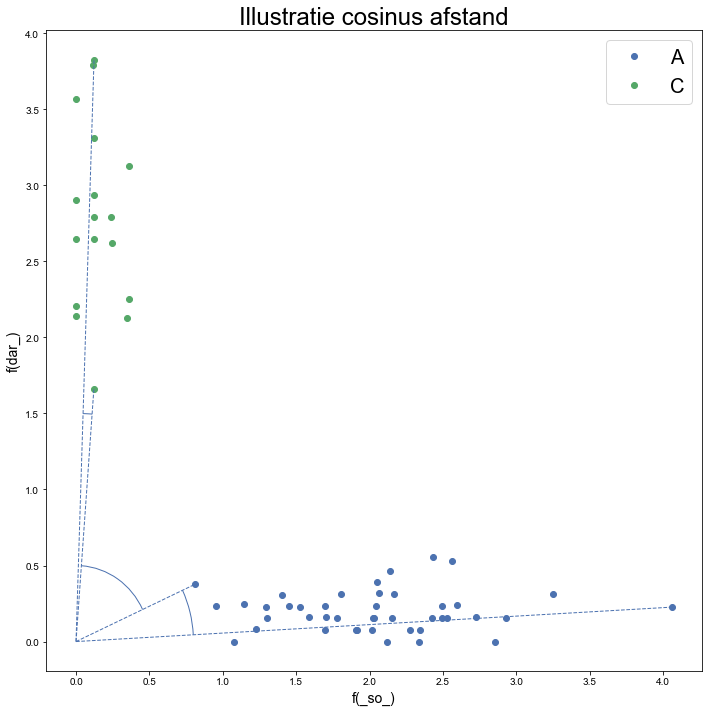

In [12]:
from matplotlib.lines import Line2D
from matplotlib.patches import Arc

labels = np.array(labels)

predictions = []

X = scaler.fit_transform(vectorizer.fit_transform(texts).toarray())


X = scaler.fit_transform(vectorizer.fit_transform(texts).toarray())

ex_A = labels == 'A'
ex_C = labels == 'C'

soe_idx = vectorizer.get_feature_names().index(' so ')
dar_idx = vectorizer.get_feature_names().index(' dar')

A = X[ex_A][:, (soe_idx, dar_idx)]
C = X[ex_C][:, (soe_idx, dar_idx)]

plt.figure(figsize=(10, 10))
plt.plot(A[:, 0], A[:, 1], 'o', label='A')
plt.plot(C[:, 0], C[:, 1], 'o', label='C')

a_min = A[A[:, 0].argmin()]
line_1 = Line2D([0.0, a_min[0]], [0.0, a_min[1]], 1, '--') 

c_min = C[C[:, 1].argmin(), :]
line_2 = Line2D([0.0, c_min[0]], [0.0, c_min[1]], 1, '--')

a_max = A[A[:, 0].argmax()]
line_3 = Line2D([0.0, a_max[0]], [0.0, a_max[1]], 1, '--')    

c_max = C[C[:, 1].argmax(), :]
line_4 = Line2D([0.0, c_max[0]], [0.0, c_max[1]], 1, '--')    

ax = plt.gca()
ax.add_line(line_1)
ax.add_line(line_2)
ax.add_line(line_3)
ax.add_line(line_4)

angle_plot = get_angle_plot(line_1, line_2, 1)
ax.add_patch(angle_plot) # To display the angle arc

angle_plot = get_angle_plot(line_1, line_3, 1.6)
ax.add_patch(angle_plot) # To display the angle arc

angle_plot = get_angle_plot(line_2, line_4, 3)
ax.add_patch(angle_plot) # To display the angle arc


plt.xlabel('f(_so_)', size= 14)
plt.ylabel('f(dar_)', size=14)
plt.legend(prop={'size': 20})
plt.tight_layout()
plt.title('Illustratie cosinus afstand', size=24)
plt.tight_layout()
plt.savefig('../figures/fig2.pdf')

We are now ready to do the leave-one-out experiment:

In [13]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

for train, test in loo.split(X):
    # separate the test item from the training items:
    train_X, test_X = X[train, :], X[test, :]
    train_y, test_y = labels[train], labels[test]
    
    # fit and predict:
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)[0]
    print(f'{test_y[0]} -> {pred}', end=' | ')
        
    # collect the results:
    predictions.append(pred)

A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | A -> A | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | B -> B | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | C -> C | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | D -> D | E -> E | E -> E | E -> E | E -> E | E -> E | E -> E | E -> E | E -> E | E -> E | E -> E | 

The output of the previous code block shows that we obtain a good accuracy. We can measure this using the accuracy score:

In [14]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(labels, predictions)
print('leave-one-out accuracy score:', acc)

leave-one-out accuracy score: 1.0


Plotting the results as a so-called confusion matrix is equally insightful. For this, we define an auxiliary function that can take of the plotting:

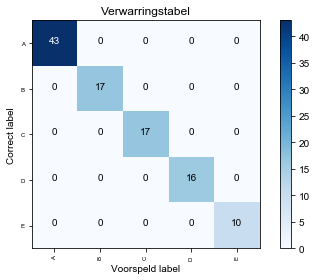

In [15]:
from itertools import product
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(gold, silver, title):
    plt.clf()
    T = gold
    P = silver
    target_names = sorted(set(T + P))
    cm = confusion_matrix(T, P, labels=target_names)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    np.set_printoptions(precision=2)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tick_params(labelsize=6)
    plt.title('Verwarringstabel')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Correct label')
    plt.xlabel('Voorspeld label')
    plt.tight_layout()
    plt.savefig(title)
    plt.show()
    plt.close()

plot_confusion_matrix(list(labels), predictions, title='../figures/fig3.pdf')

## Different parametrizations

As you can see, the results from the previous section look great, in the sense that not even a single segment gets wrongly attributed. However, it is important that we do not **overestimate** the importance of this result: apart from scribal characteristics, the attributor can also rely on other, topic-related feature, because the segments come from topically coherent sections of the text. To estimate the actual performance of our classifier we can only rely on the attribution results for the external fragments (see below).

Nevertheless, it might be interesting to have a look at the effect of varying certain parameters in our experiments. Here, we shall explore the effect of different vocabulary sizes (starting from very small vocabularies) and the size of the segments. The latter parameter is tricky: larger text blocks are generally easier to attribute, but since our training data is limited, larger segments also imply fewer training data instances. We vary both paramaters between 50 and 3000, with step sizes of 50 (60 values in total). This yields 3600 possible combinations that we can test.

In [16]:
values = list(range(50, 3050, 50))
accuracies = np.zeros((len(values), len(values)))
print(accuracies.shape)

(60, 60)


Below, we run the actual experiment -- watch out: this cell will take quite a bit of time to execute.

In [18]:
for i, j in product(range(len(values)), repeat=2):
    feat, segm = values[i], values[j]
    texts, labels = segment(scribes, segment_length=segm,
                        max_nb_segments=None, shuffle=False)
    
    vectorizer = TfidfVectorizer(max_features=feat, analyzer='char_wb',
                             ngram_range=(NGRAM_LENGTH, NGRAM_LENGTH),
                             use_idf=False, norm='l1')
    scaler = StandardScaler(with_mean=False)
    labels = np.array(labels)
    predictions = []
    X = scaler.fit_transform(vectorizer.fit_transform(texts).toarray())
    loo = LeaveOneOut()

    for train, test in loo.split(X):
        train_X, test_X = X[train, :], X[test, :]
        train_y, test_y = labels[train], labels[test]

        clf.fit(train_X, train_y)
        predictions.append(clf.predict(test_X)[0])
    
    acc = accuracy_score(labels, predictions)
    
    accuracies[i, j] = acc
    
    print(f'V={feat}, S={segm}, A={acc}')
    

V=50, S=50, A=0.41391509433962265
V=50, S=100, A=0.44786729857819907
V=50, S=150, A=0.5780141843971631


KeyboardInterrupt: 

Let us visualize these results as a heatmap:

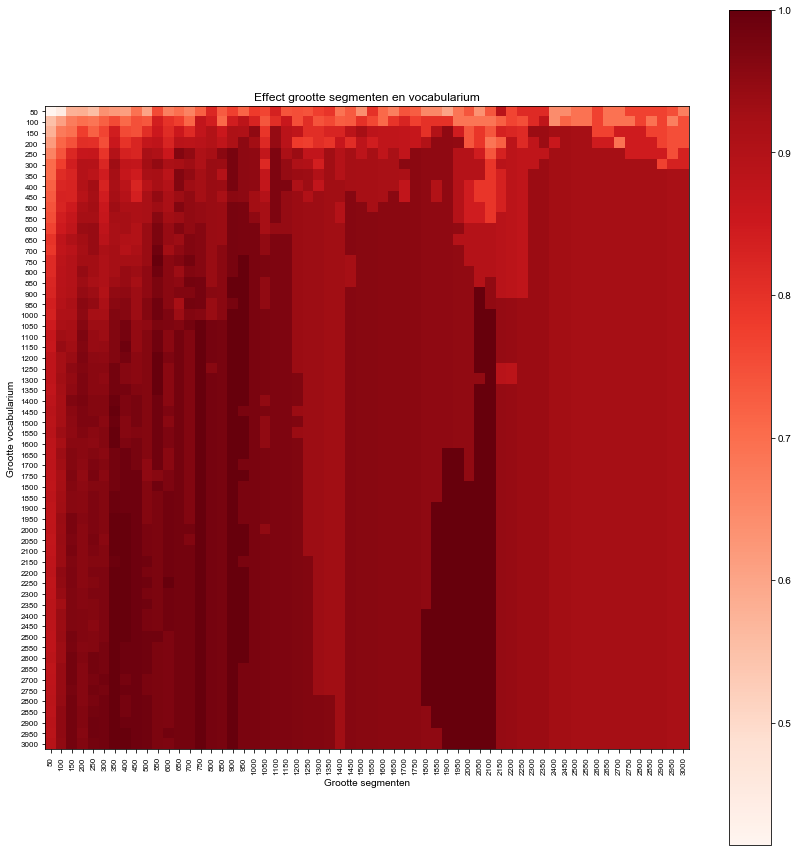

In [42]:
plt.figure(figsize=(12, 12))
plt.imshow(accuracies, interpolation='nearest', cmap=plt.cm.Reds)
plt.tick_params(labelsize=8)
plt.title('Effect grootte segmenten en vocabularium')
plt.colorbar()
tick_marks = np.arange(len(values))
plt.xticks(tick_marks, values, rotation=90)
plt.yticks(tick_marks, values)

plt.tight_layout()
plt.ylabel('Grootte vocabularium')
plt.xlabel('Grootte segmenten')
plt.tight_layout()
plt.savefig('../figures/fig4.pdf')

These results confirm what we could expect: the best results are obtained with larger vocabularies and larger text blocks.

## Feature analysis

### Mann-Whitney

In [19]:
texts, labels = segment(scribes, segment_length=400)
X = vectorizer.fit_transform(texts).toarray()
X = scaler.fit_transform(X)
print(X.shape)
feature_names = [f.replace(' ', '_') for f in vectorizer.get_feature_names()]

(103, 50)


In [20]:
import pandas as pd
df = pd.DataFrame(X, columns=feature_names)
df['scribes'] = labels
df.head()

,_als,_dae,_dat,_die,_doe,_end,_hem,_her,_hi_,_ic_,...,nder,nen_,oet_,onde,ren_,ten_,ter_,van_,was_,scribes
0,2.142220,2.824513,5.952152,6.355130,6.722328,7.875576,2.424908,1.237546,2.558170,2.944909,...,4.633060,4.091316,3.859484,4.701036,4.092974,2.966832,4.718584,3.059392,4.370765,A
1,3.882905,3.036044,5.149124,6.186164,7.151849,8.654197,4.395294,2.492365,4.153836,2.949852,...,4.509879,3.575456,1.907878,3.744039,2.760471,4.033174,4.000467,2.239463,2.122039,A
2,1.064928,2.282125,6.520537,5.967425,6.174999,9.890964,5.625461,1.678514,4.553990,2.255862,...,4.350413,4.664944,1.482558,2.675298,2.145084,4.178754,5.288277,2.320297,3.371241,A
3,3.632992,2.382470,5.200073,6.348138,6.931380,8.331465,3.979745,1.790337,3.618251,1.945986,...,4.308793,6.794580,3.263054,3.842070,2.213086,3.010019,4.671448,3.392432,3.774508,A
4,3.523009,2.132626,6.994642,6.863539,5.403593,8.789506,4.116549,3.720293,3.028068,2.166641,...,5.880642,2.767332,2.214989,4.368129,4.463863,4.986446,3.157292,2.759130,2.534013,A


-> Comparing scribe A to rest
-> Comparing scribe B to rest
-> Comparing scribe C to rest
-> Comparing scribe D to rest
-> Comparing scribe E to rest


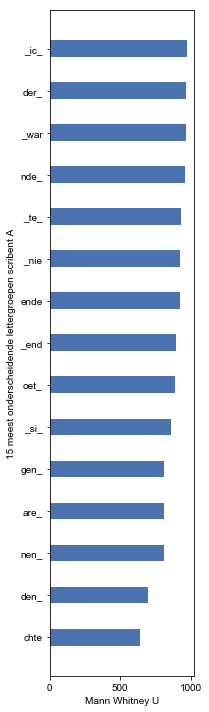

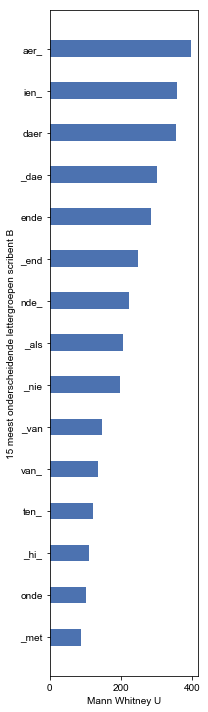

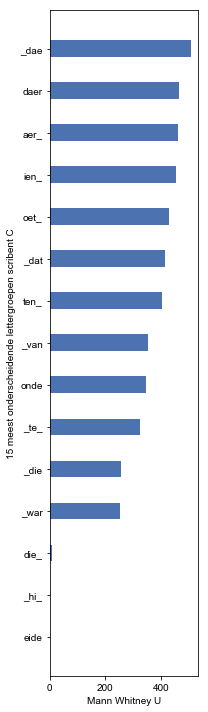

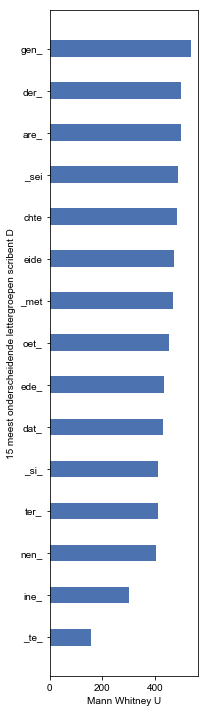

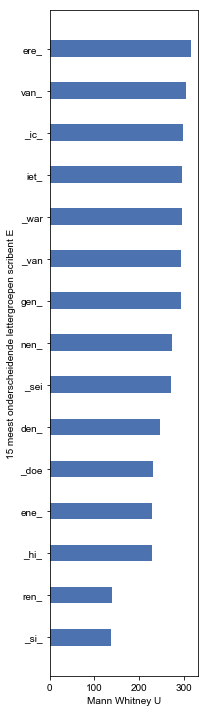

In [21]:
from scipy.stats import mannwhitneyu
width = .4
m = 15

for scribe in sorted(set(labels)):
    print('-> Comparing scribe', scribe, 'to rest')
    A = df[df['scribes'] == scribe]
    B = df[df['scribes'] != scribe]

    results = []
    for word in feature_names:
        stat, pval = mannwhitneyu(A[word], B[word])
        results.append((stat, word, pval))

    results = sorted(results)

    T = []
    for _, word, _ in results[:m]:
        x = df[word].tolist()
        y = [sc if sc == scribe else 'X' for sc in df['scribes']]
        z = [word] * len(x)
        for entry in zip(x, y, z):
            T.append(entry)
    plt.figure(figsize=(15, 5))
    wdf = pd.DataFrame(T, columns=('freq', 'scribe', 'tetragram'))
    ax = sb.violinplot(x='tetragram', y='freq', hue='scribe',
                        data=wdf, palette="muted", split=True,

                        hue_order=[scribe, 'X'])
    plt.savefig(f'../figures/fig6{scribe.lower()}.pdf')
    plt.clf()
    
    # plot
    fig = plt.figure(figsize=(3, 10))
    t_scores, t_labels, _ = zip(*results[:m])
    pos = np.arange(m) - (width / 2)
    
    ax1 = fig.add_subplot(111)
    plt.barh(pos, t_scores, width, label=scribe)
    
    plt.yticks(pos, t_labels[::-1])
    ax1.set_ylabel(f'{m} meest onderscheidende lettergroepen scribent {scribe}')
    plt.xlabel('Mann Whitney U')
    plt.tight_layout()
    plt.savefig(f'../figures/fig5{scribe.lower()}.pdf')
    

## External fragments

In [67]:
vectorizer = TfidfVectorizer(max_features=2000, analyzer='char_wb',
                             ngram_range=(4, 4),
                             use_idf=False, norm='l1')
scaler = StandardScaler(with_mean=False)
clf = KNeighborsClassifier(metric='cosine', n_neighbors=1,
                           algorithm='brute', weights='uniform')

In [68]:
def preprocess_file(fn, target_scribes):

    with open(fn, 'r') as f:
        xml_text = f.read()

    root = etree.fromstring(xml_text)

    scribes, current_scribe = {}, None

    for line in root.findall('.//l'):
        for child in list(line):
            if child.tag == 'scribe':
                current_scribe = child.get('id')
                if current_scribe not in scribes and \
                  current_scribe in target_scribes:
                    scribes[current_scribe] = []

        if current_scribe and current_scribe in target_scribes:

            # ignore lines with a damage tag:
            damaged = False
            for child in line:
                if child.tag == 'damage':
                    print(' '.join([t.strip() for t in line.itertext()]))
                    damaged = True
                    break

            if not damaged:
                line_text = ' '.join([t.strip() for t in line.itertext()])
                line_text = ''.join([c for c in line_text if c.isalpha() or c.isspace()])

                scribes[current_scribe].append(line_text.strip().lower())

    return scribes

In [69]:
import glob

def preprocess_dir(dir_, target_scribes):

    scribes = {}

    for fn in sorted(glob.glob(dir_ + '*.xml')):

        print(fn)

        tmp_scribes = preprocess_file(fn, target_scribes=target_scribes)

        if tmp_scribes:
            for scribe in tmp_scribes:
                if scribe not in scribes:
                    scribes[scribe] = []
                scribes[scribe].extend(tmp_scribes[scribe])

    return scribes

In [70]:
train_scribes = preprocess_file(fn='../data/compilation/01Lanc.xml',
                                target_scribes=['A', 'B', 'C', 'D', 'E'])

train_scribes['B'].extend(preprocess_file(fn='../data/compilation/02Perc.xml',
                          target_scribes=['B'])['B'])

for scribe, lines in train_scribes.items():
    train_scribes[scribe] = tuple(lines)

for scribe, lines in train_scribes.items():
    print(f'{scribe} -> {len(lines)} lines')

    
train_texts, train_labels = segment(train_scribes,
                                    segment_length=500)

A -> 17475 lines
B -> 7085 lines
C -> 7080 lines
D -> 6639 lines
E -> 4264 lines


(Only for visualization purposes:)

../data/external/BrRose.xml
../data/external/Caesar.xml
../data/external/CassK1350.xml
../data/external/Frene.xml
../data/external/H52.xml
../data/external/Lanc_Br.xml
../data/external/Oring.xml
A -> 10890 lines
C -> 564 lines
D -> 481 lines
B -> 396 lines


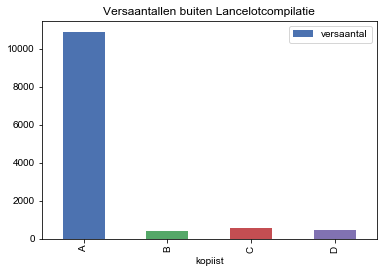

In [71]:
test_scribes = preprocess_dir('../data/external/',
                              target_scribes=['A', 'B', 'C', 'D'])
for scribe, lines in test_scribes.items():
    print(f'{scribe} -> {len(lines)} lines')

df = pd.DataFrame()
df['kopiist'] = sorted(test_scribes.keys())
df['versaantal'] = [len(test_scribes[s]) for s in sorted(test_scribes.keys())]
df.plot(kind='bar', x='kopiist', y='versaantal')
plt.title('Versaantallen buiten Lancelotcompilatie')
plt.savefig('../figures/fig1b.pdf')

In [72]:
A = preprocess_dir('../data/external/', target_scribes=['A'])
a_texts, a_labels = segment(A, segment_length=600) 

../data/external/BrRose.xml
../data/external/Caesar.xml
../data/external/CassK1350.xml
../data/external/Frene.xml
../data/external/H52.xml
../data/external/Lanc_Br.xml
../data/external/Oring.xml


In [73]:
rest_scribes = preprocess_dir('../data/external/',
                              target_scribes=['B', 'C', 'D'])

test_texts, test_labels = segment(rest_scribes,
                                  segment_length=None)

test_texts = a_texts + test_texts
test_labels = a_labels + test_labels

../data/external/BrRose.xml
../data/external/Caesar.xml
../data/external/CassK1350.xml
../data/external/Frene.xml
../data/external/H52.xml
../data/external/Lanc_Br.xml
../data/external/Oring.xml


In [78]:
train_X = vectorizer.fit_transform(train_texts).toarray()
train_X = scaler.fit_transform(train_X)

test_X = vectorizer.transform(test_texts).toarray()
test_X = scaler.transform(test_X)

clf.fit(train_X, train_labels)
silver = clf.predict(test_X)

In [79]:
print(silver)

['A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'B' 'C' 'B']


//anaconda/envs/clean36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


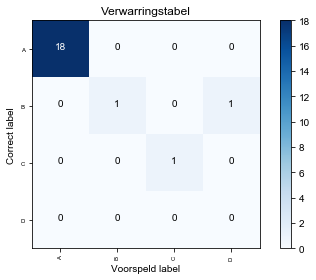

Test acc: 0.952380952381


In [80]:
from sklearn.metrics import accuracy_score
plot_confusion_matrix(list(silver), list(test_labels), title='../figures/fig7.pdf')
acc = accuracy_score(silver, test_labels)
print('Test acc:', acc)